In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath("E:/aleksa_praksa/nlp_internship/data-internship")

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

print("Project root added:", PROJECT_ROOT)

Project root added: E:\aleksa_praksa\nlp_internship\data-internship


## Clustering

Group reviews by similar content/topic/experience?

Clustering by topics - Understanding what people talk about, What is the review about
(themes, topics, issues, features, experiences)

Group together reviews that talk about the same things (need meaning words: Nouns govore o topicu - bez njih ostaje samo sentiment, Adjectives - descriptions, Verbs - what happened, problems like broke).

## EDA AND PREPROCESSING
 
- Category distribution (number of reviews per category), number of category per language) 
- drop emojis, zh and ja

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import numpy as np
import pickle
import emoji
import spacy
from wordcloud import WordCloud
from sklearn.decomposition import PCA
import hdbscan
from sentence_transformers import SentenceTransformer
from collections import Counter
import joblib


In [3]:
from src.clustering.kmenas_clustering import elbow_method, run_kmeans
from src.text_processing.clastering_vectorizer import lang_vectorizer_tfidf

In [4]:
df = pd.read_csv(r"E:/aleksa_praksa/nlp_internship/data-internship/data/internship_nlp_dataset.csv", sep="#") 
df.head() 

Unnamed: 0  index   review_id          product_id          reviewer_id  \
0           0      0  de_0203609  product_de_0865382  reviewer_de_0267719   
1           1      1  de_0559494  product_de_0678997  reviewer_de_0783625   
2           2      2  de_0238777  product_de_0372235  reviewer_de_0911426   
3           3      3  de_0477884  product_de_0719501  reviewer_de_0836478   
4           4      4  de_0270868  product_de_0022613  reviewer_de_0736276   

   stars                                        review_body  \
0      1     Armband ist leider nach 1 Jahr kaputt gegangen   
1      1                 In der Lieferung war nur Ein Akku!   
2      1  Ein Stern, weil gar keine geht nicht. Es hande...   
3      1  Dachte, das wären einfach etwas festere Binden...   
4      1  Meine Kinder haben kaum damit gespielt und nac...   

                review_title language  product_category  
0  Leider nach 1 Jahr kaputt       de            sports  
1   EINS statt ZWEI Akkus!!!       de  home_improvement  
2            Achtung Abzocke       de         drugstore  
3          Zu viel des Guten       de         drugstore  
4     Qualität sehr schlecht       de               toy

In [5]:
def preprocess_reviews(df):

    # drop columns
    df.drop(columns=['Unnamed: 0', 'index', 'review_id', 'product_id', 'reviewer_id', 'stars'],inplace=True)

    # Remove Chinese & Japanese
    df = df[~df['language'].isin(['zh', 'ja'])].copy()
    
    # Combine title and body and handle Missing Values
    # remove spaces and whitespace from beginning & end of the string - beacuse of length
    df['combined_text'] = (df['review_title'].fillna('') + ' ' + df['review_body'].fillna('')).str.strip()
    
    # Remove emojis
    df['combined_text'] = df['combined_text'].apply(lambda x: emoji.replace_emoji(x, ''))
    
    # length
    df['word_count'] = df['combined_text'].str.split().str.len()
    
    # Drop duplicates
    df = df.drop_duplicates(subset=['combined_text'])
    
    return df


In [6]:
# df = preprocess_reviews(df)

In [7]:
df.head()

Unnamed: 0  index   review_id          product_id          reviewer_id  \
0           0      0  de_0203609  product_de_0865382  reviewer_de_0267719   
1           1      1  de_0559494  product_de_0678997  reviewer_de_0783625   
2           2      2  de_0238777  product_de_0372235  reviewer_de_0911426   
3           3      3  de_0477884  product_de_0719501  reviewer_de_0836478   
4           4      4  de_0270868  product_de_0022613  reviewer_de_0736276   

   stars                                        review_body  \
0      1     Armband ist leider nach 1 Jahr kaputt gegangen   
1      1                 In der Lieferung war nur Ein Akku!   
2      1  Ein Stern, weil gar keine geht nicht. Es hande...   
3      1  Dachte, das wären einfach etwas festere Binden...   
4      1  Meine Kinder haben kaum damit gespielt und nac...   

                review_title language  product_category  
0  Leider nach 1 Jahr kaputt       de            sports  
1   EINS statt ZWEI Akkus!!!       de  home_improvement  
2            Achtung Abzocke       de         drugstore  
3          Zu viel des Guten       de         drugstore  
4     Qualität sehr schlecht       de               toy

In [8]:
df['language'].unique()

array(['de', 'en', 'es', 'fr', 'zh', 'ja'], dtype=object)

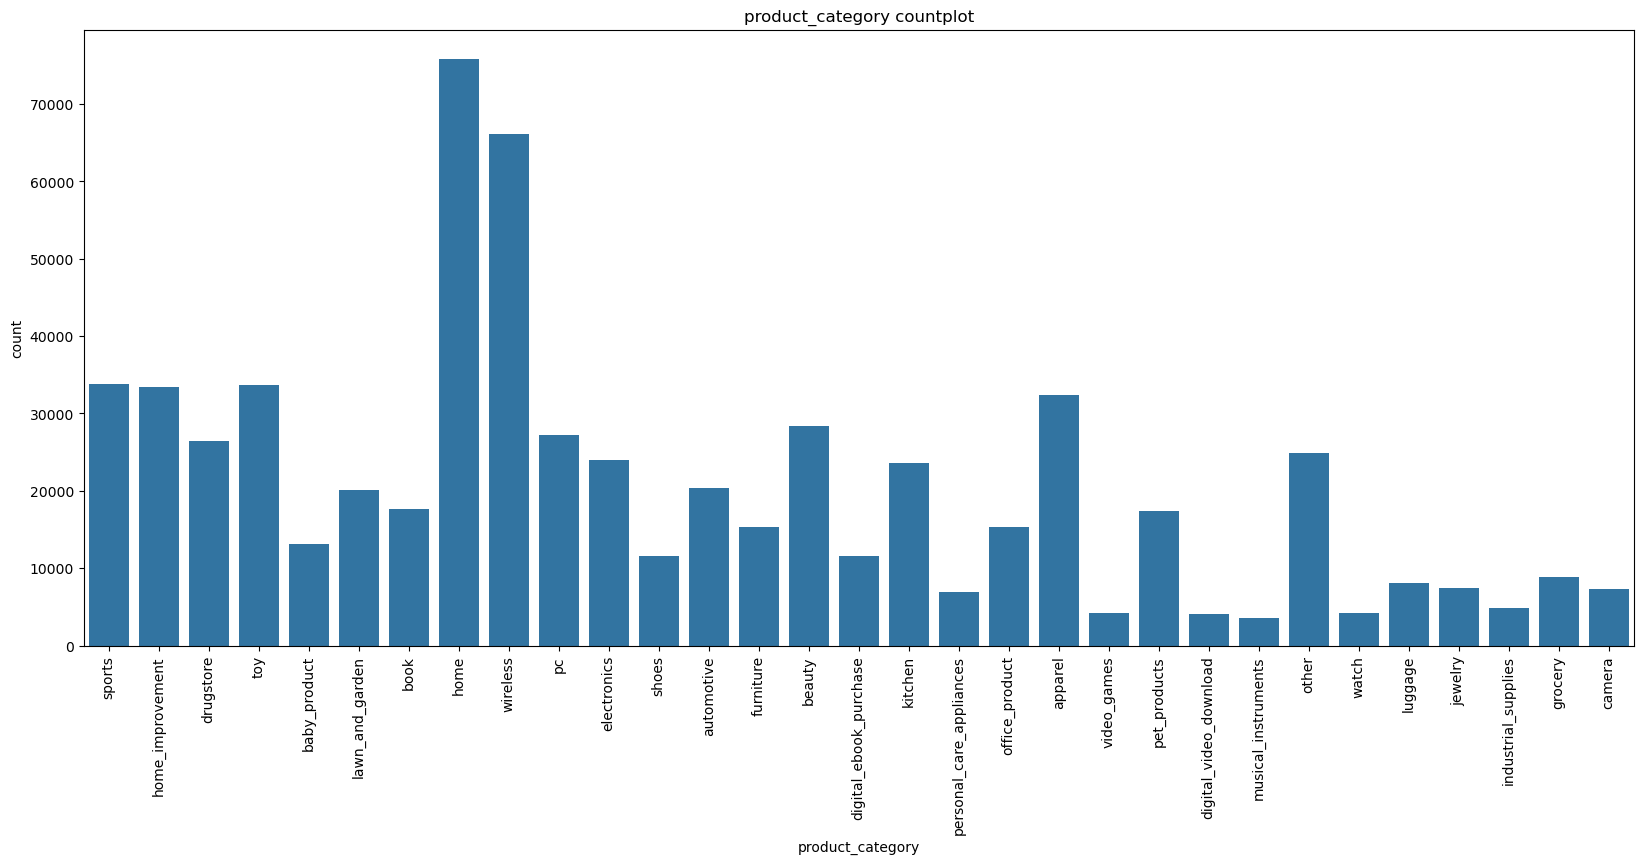

In [9]:
plt.figure(figsize = (20,8))
sns.countplot(data = df, x = 'product_category')
plt.xticks(rotation=90)
plt.title('product_category countplot')
plt.show()

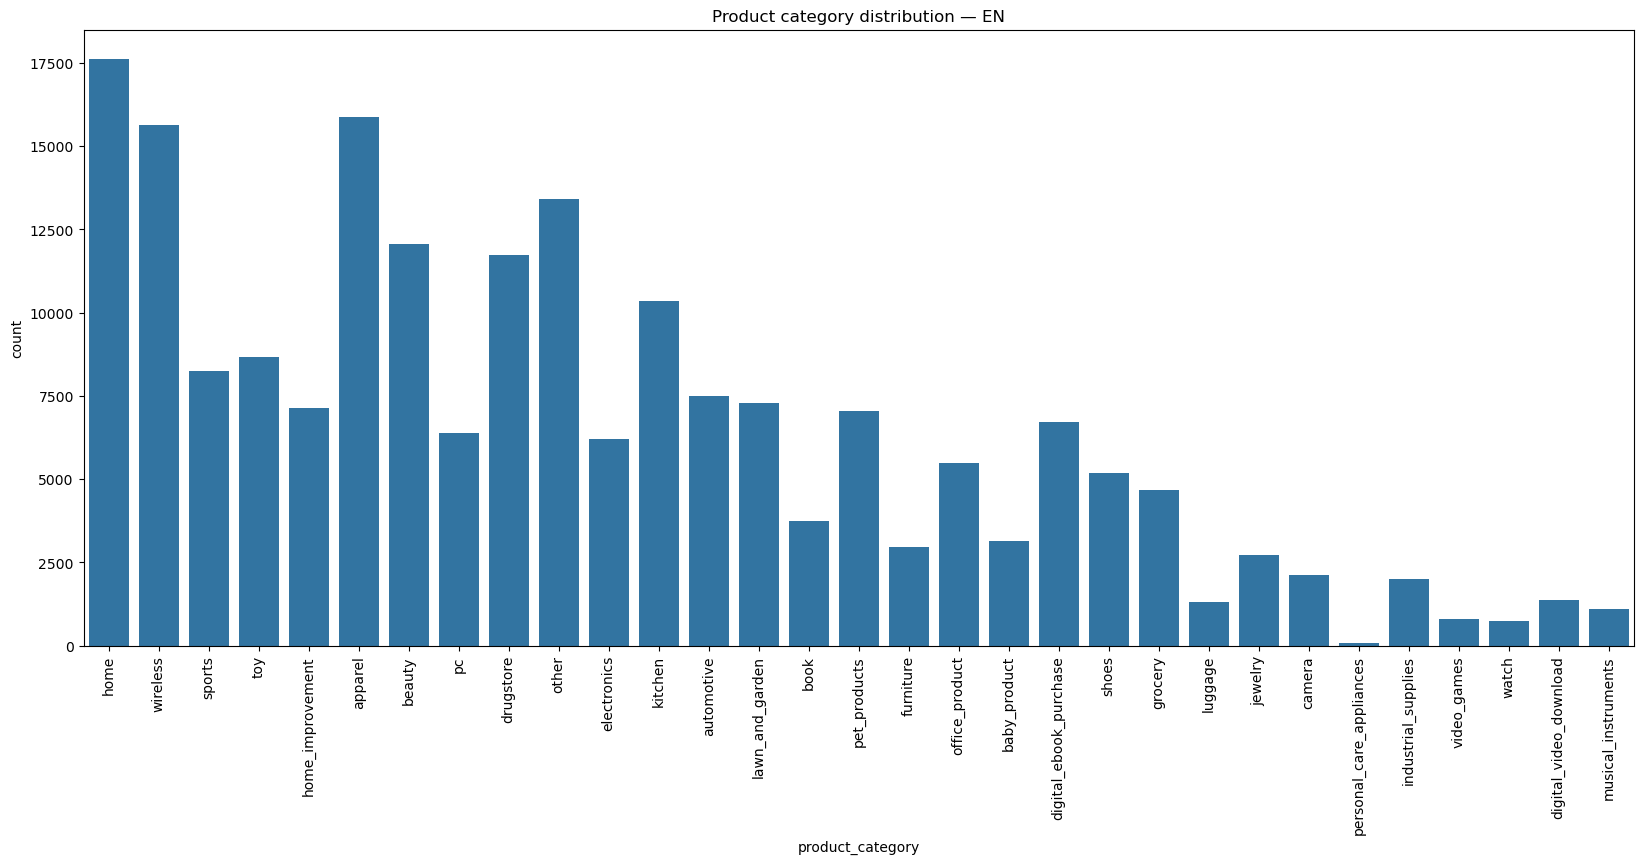

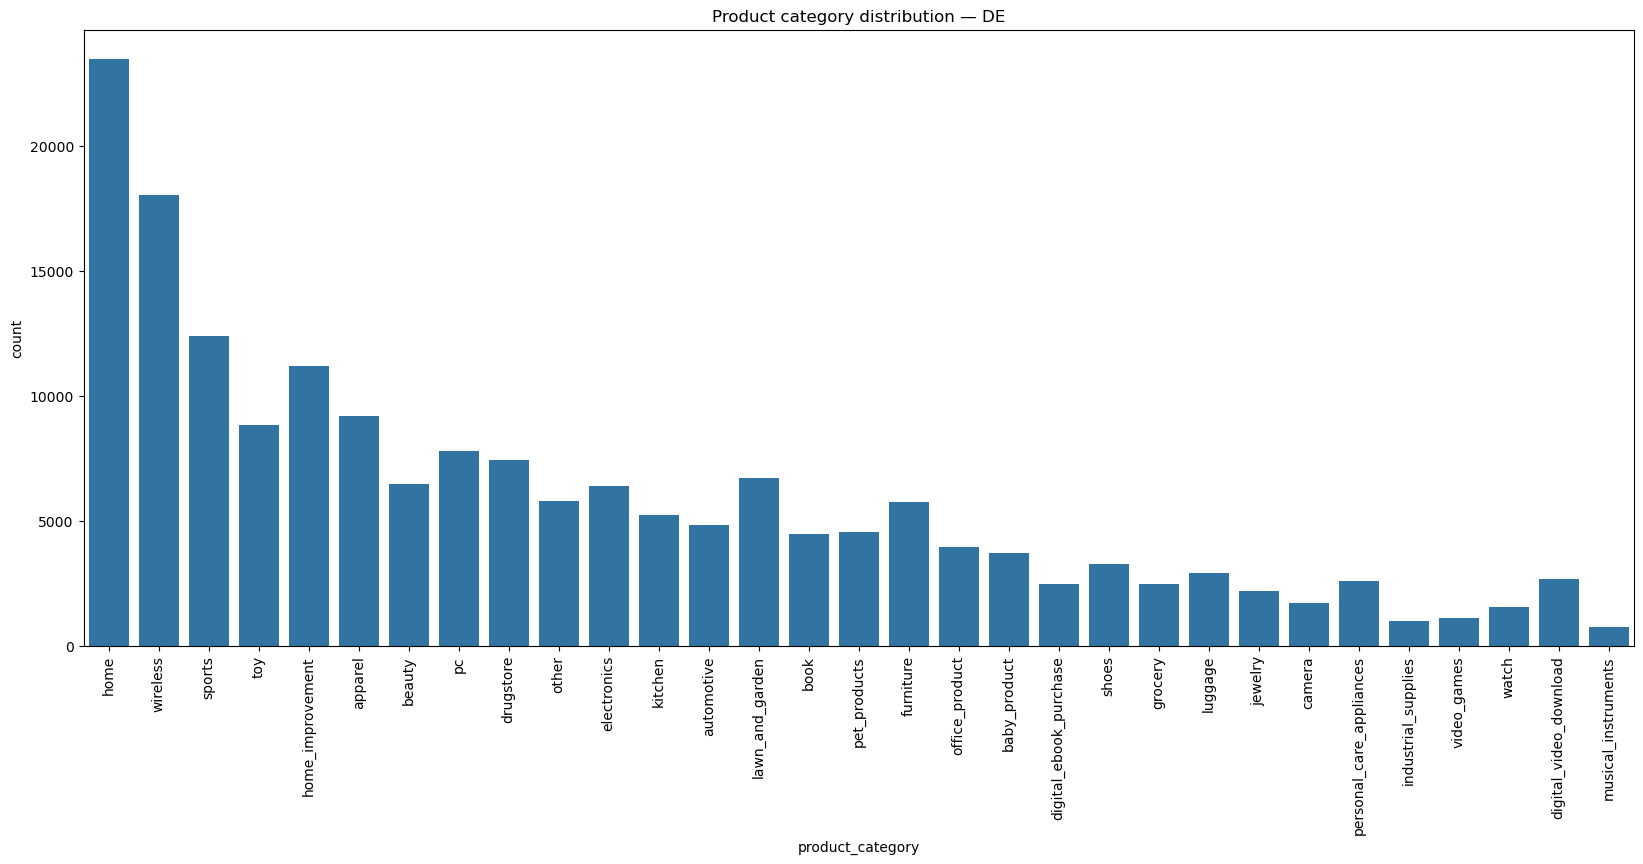

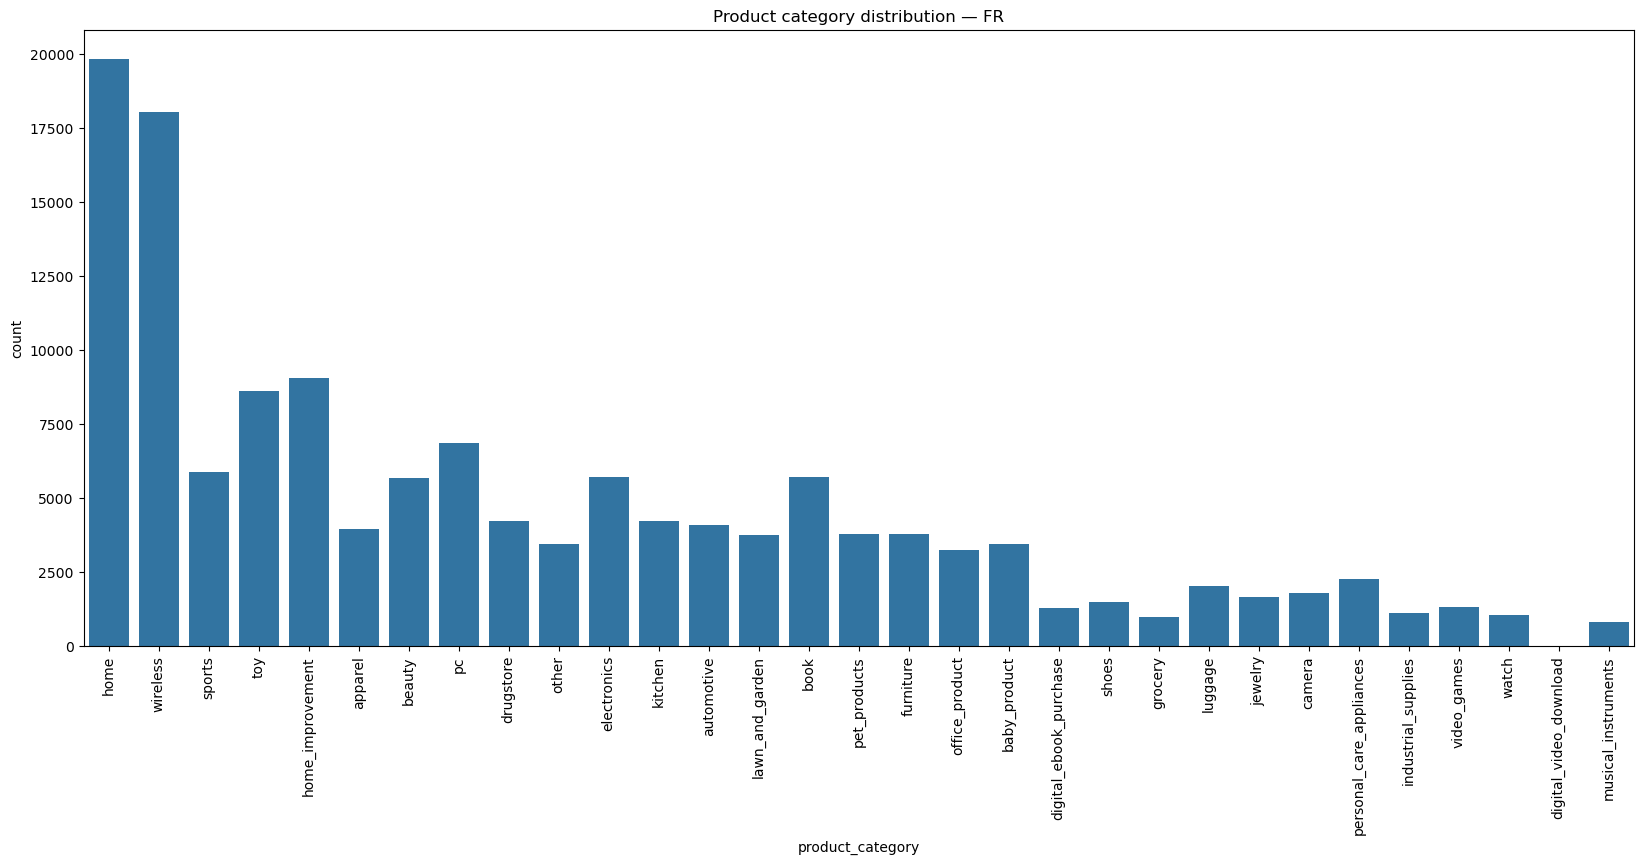

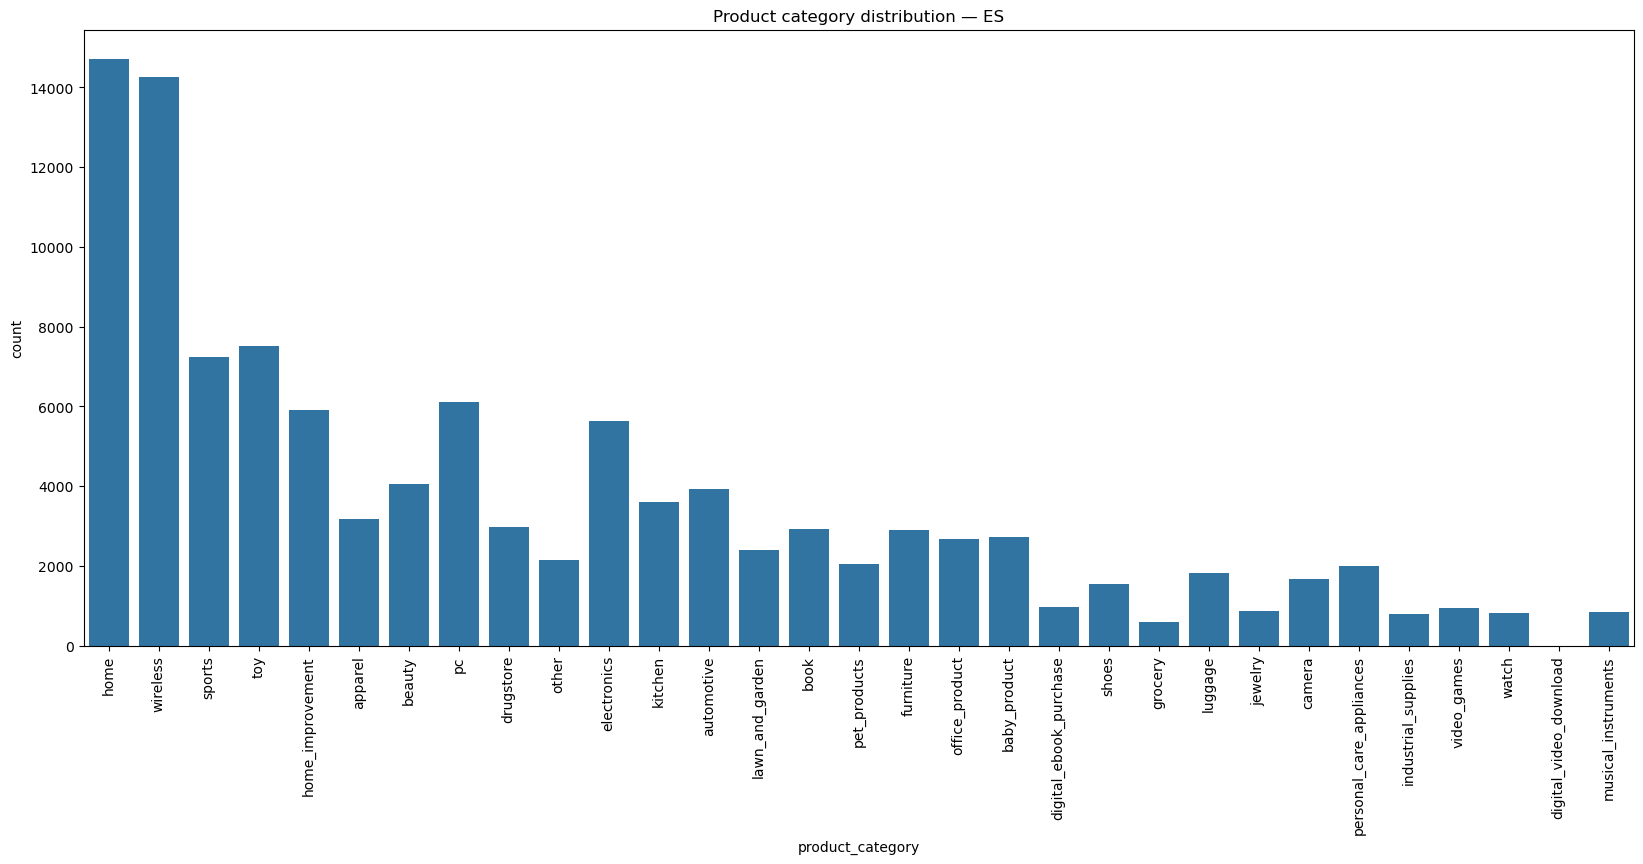

In [10]:
languages = ["en", "de", "fr", "es"]

for lang in languages:
    plt.figure(figsize=(20, 8))
    
    sns.countplot(data=df[df["language"] == lang], x="product_category", order=df["product_category"].value_counts().index)
    
    plt.xticks(rotation=90)
    plt.title(f"Product category distribution — {lang.upper()}")
    plt.show()


# Text preprocessing

- Remove reviews that contain no meaningful tokens (0 ouns + 0 verbs + 0 adjectives) - (they dont have topic info, only maybe sentiment and star).
- lowercasing, removing punctuation
- stopwords
- lemmatization



In [11]:
nlp_models = {
    "en": spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"]),
    "de": spacy.load("de_core_news_sm", disable=["parser", "ner", "textcat"]),
    "fr": spacy.load("fr_core_news_sm", disable=["parser", "ner", "textcat"]),
    "es": spacy.load("es_core_news_sm", disable=["parser", "ner", "textcat"])
}


In [12]:
def preprocess_and_filter(row_text, lang):
     
    nlp = nlp_models.get(lang)
    doc = nlp(row_text)

    tokens = []
    
    for token in doc:
        if (
            token.pos_ in {"NOUN", "VERB", "ADJ"} and  
            token.is_stop == False and                 
            token.is_alpha                            
        ):
            lemma = token.lemma_.lower()         
            tokens.append(lemma)

            #  pos = token.pos_         # save POS
            #  tokens.append((lemma, pos))  # store tupl 
    
    return tokens


In [13]:
def apply_pos_filtering(df):

    df['tokens'] = df.apply(lambda row: preprocess_and_filter(row['combined_text'], row['language']), axis=1)
    
    return df


In [14]:
# df = apply_pos_filtering(df)

In [15]:
df.head()

Unnamed: 0  index   review_id          product_id          reviewer_id  \
0           0      0  de_0203609  product_de_0865382  reviewer_de_0267719   
1           1      1  de_0559494  product_de_0678997  reviewer_de_0783625   
2           2      2  de_0238777  product_de_0372235  reviewer_de_0911426   
3           3      3  de_0477884  product_de_0719501  reviewer_de_0836478   
4           4      4  de_0270868  product_de_0022613  reviewer_de_0736276   

   stars                                        review_body  \
0      1     Armband ist leider nach 1 Jahr kaputt gegangen   
1      1                 In der Lieferung war nur Ein Akku!   
2      1  Ein Stern, weil gar keine geht nicht. Es hande...   
3      1  Dachte, das wären einfach etwas festere Binden...   
4      1  Meine Kinder haben kaum damit gespielt und nac...   

                review_title language  product_category  
0  Leider nach 1 Jahr kaputt       de            sports  
1   EINS statt ZWEI Akkus!!!       de  home_improvement  
2            Achtung Abzocke       de         drugstore  
3          Zu viel des Guten       de         drugstore  
4     Qualität sehr schlecht       de               toy

In [16]:
# df[df['tokens'].map(len) == 0]


In [17]:
# (df['tokens'].map(len) == 0).sum()


In [18]:
# df = df[df['tokens'].map(len) > 0]

In [19]:
# df["tokens"].apply(len).describe() # token counts


In [ ]:

save_path = r"E:\aleksa_praksa\nlp_internship\data-internship\data\tokenized_dataset_for_clustering.pkl"

# df.to_pickle(save_path)


In [ ]:
load_path = r"E:\aleksa_praksa\nlp_internship\data-internship\data\tokenized_dataset_for_clustering.pkl"

df = pd.read_pickle(load_path)
df

review_body  \
0          Armband ist leider nach 1 Jahr kaputt gegangen   
1                      In der Lieferung war nur Ein Akku!   
2       Ein Stern, weil gar keine geht nicht. Es hande...   
3       Dachte, das wären einfach etwas festere Binden...   
4       Meine Kinder haben kaum damit gespielt und nac...   
...                                                   ...   
628359  Tester aujourd’hui Étanchéité parfait Éclairag...   
628360                    tres bon televiseur rien a dire   
628361  Je ne suis as un dj et ce que j'entends avec c...   
628362  Bon verre trempé rempli tous l’écran très faci...   
628363  Parfait pour une coque en silicone, qui n'a à ...   

                                             review_title language  \
0                               Leider nach 1 Jahr kaputt       de   
1                                EINS statt ZWEI Akkus!!!       de   
2                                         Achtung Abzocke       de   
3                                       Zu viel des Guten       de   
4                                  Qualität sehr schlecht       de   
...                                                   ...      ...   
628359                           Projecteur phare étanche       fr   
628360                                              super       fr   
628361                    Vive les offres reconditionnées       fr   
628362                                       verre trempé       fr   
628363  Parfait, rapide et conforme à ce que je cherchais       fr   

        product_category                                      combined_text  \
0                 sports  Leider nach 1 Jahr kaputt Armband ist leider n...   
1       home_improvement  EINS statt ZWEI Akkus!!! In der Lieferung war ...   
2              drugstore  Achtung Abzocke Ein Stern, weil gar keine geht...   
3              drugstore  Zu viel des Guten Dachte, das wären einfach et...   
4                    toy  Qualität sehr schlecht Meine Kinder haben kaum...   
...                  ...                                                ...   
628359        automotive  Projecteur phare étanche Tester aujourd’hui Ét...   
628360             other              super tres bon televiseur rien a dire   
628361       electronics  Vive les offres reconditionnées Je ne suis as ...   
628362          wireless  verre trempé Bon verre trempé rempli tous l’éc...   
628363          wireless  Parfait, rapide et conforme à ce que je cherch...   

        word_count                                             tokens  
0               13                                   [armband, gehen]  
1               11                           [akkus, lieferung, akku]  
2               64  [achtung, abzocke, stern, handeln, brauchen, s...  
3               36  [gute, dachte, fester, binde, groß, alway, ver...  
4               24  [qualität, kind, spielen, monat, riss, naht, l...  
...            ...                                                ...  
628359          15  [projecteur, phare, étanche, tester, parfaire,...  
628360           7                           [super, bon, televiseur]  
628361          36  [offre, reconditionner, dj, entendre, casque, ...  
628362          12  [verre, trempé, bon, verre, trempé, remplir, é...  
628363          40  [rapide, conforme, chercher, parfait, coque, s...  

[626465 rows x 7 columns]

## EDA 2
- top words - only for eng just to see
- POS by category: Top nouns per product category - only for engl

In [22]:
df_en = df[df['language'] == 'en']

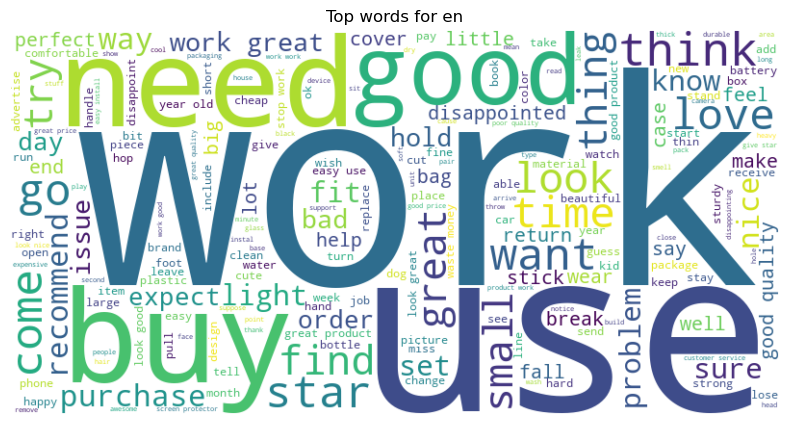

In [23]:
en_tokens = [token for row in df_en['tokens'] for token in row]
en_text = " ".join(en_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(en_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title(f"Top words for en")
plt.show()

In [24]:
results = {}

for cat in df_en["product_category"].unique():
        df_cat = df_en[df_en["product_category"] == cat]

        all_tokens = [token for row in df_cat["tokens"] for token in row]

        # Count frequencies
        token_counts = Counter(all_tokens)

        
        top_15_words = token_counts.most_common(15)
        results[cat] = top_15_words



In [25]:
for cat, words in results.items():
    print("\n", cat)
    print(words)


 furniture
[('look', 776), ('chair', 702), ('good', 660), ('great', 622), ('buy', 535), ('product', 504), ('nice', 463), ('easy', 459), ('come', 394), ('quality', 391), ('price', 386), ('piece', 383), ('assemble', 371), ('bed', 358), ('table', 357)]

 home_improvement
[('work', 3027), ('light', 2435), ('great', 1608), ('good', 1483), ('product', 1338), ('look', 1170), ('buy', 1130), ('use', 1000), ('easy', 852), ('need', 842), ('bulb', 775), ('time', 739), ('come', 697), ('bright', 634), ('quality', 633)]

 home
[('great', 3604), ('work', 3528), ('good', 3422), ('look', 3186), ('product', 2735), ('buy', 2667), ('use', 2255), ('love', 2141), ('nice', 2025), ('quality', 2019), ('come', 1847), ('time', 1766), ('color', 1740), ('small', 1718), ('get', 1517)]

 wireless
[('phone', 7281), ('case', 6450), ('work', 5482), ('good', 3862), ('screen', 3781), ('great', 3402), ('charge', 2938), ('product', 2875), ('buy', 2591), ('look', 2275), ('use', 2182), ('fit', 2176), ('time', 1973), ('protec

In [26]:
# for cat in df_en["product_category"].unique():
#         df_cat = df_en[df_en["product_category"] == cat]

#         all_tokens = [token for row in df_cat["tokens"] for token in row]
#         text = " ".join(all_tokens) 

#         wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')  
#         plt.title(f"Top words for category: {cat}")
#         plt.show()

## Vectorizer 

Semantic meaning is preserved - Words with similar meaning must be close (Clustering should group similar topics together)

Word embedings: word2vec or FastTExt, sentence transformer (bes sematic undersanding), 
Embeding (numeric vector that represent text):  Tf idf (fast no sematic - baseline)

t-SNE or UMAP - dimensionality reduction techniques like t-SNE or UMAP can simplify and visualize the embedding space.

wordcloud 

In [27]:
df["text_joined"] = df["tokens"].apply(lambda x: " ".join(x))

In [28]:
df

review_body  \
0          Armband ist leider nach 1 Jahr kaputt gegangen   
1                      In der Lieferung war nur Ein Akku!   
2       Ein Stern, weil gar keine geht nicht. Es hande...   
3       Dachte, das wären einfach etwas festere Binden...   
4       Meine Kinder haben kaum damit gespielt und nac...   
...                                                   ...   
628359  Tester aujourd’hui Étanchéité parfait Éclairag...   
628360                    tres bon televiseur rien a dire   
628361  Je ne suis as un dj et ce que j'entends avec c...   
628362  Bon verre trempé rempli tous l’écran très faci...   
628363  Parfait pour une coque en silicone, qui n'a à ...   

                                             review_title language  \
0                               Leider nach 1 Jahr kaputt       de   
1                                EINS statt ZWEI Akkus!!!       de   
2                                         Achtung Abzocke       de   
3                                       Zu viel des Guten       de   
4                                  Qualität sehr schlecht       de   
...                                                   ...      ...   
628359                           Projecteur phare étanche       fr   
628360                                              super       fr   
628361                    Vive les offres reconditionnées       fr   
628362                                       verre trempé       fr   
628363  Parfait, rapide et conforme à ce que je cherchais       fr   

        product_category                                      combined_text  \
0                 sports  Leider nach 1 Jahr kaputt Armband ist leider n...   
1       home_improvement  EINS statt ZWEI Akkus!!! In der Lieferung war ...   
2              drugstore  Achtung Abzocke Ein Stern, weil gar keine geht...   
3              drugstore  Zu viel des Guten Dachte, das wären einfach et...   
4                    toy  Qualität sehr schlecht Meine Kinder haben kaum...   
...                  ...                                                ...   
628359        automotive  Projecteur phare étanche Tester aujourd’hui Ét...   
628360             other              super tres bon televiseur rien a dire   
628361       electronics  Vive les offres reconditionnées Je ne suis as ...   
628362          wireless  verre trempé Bon verre trempé rempli tous l’éc...   
628363          wireless  Parfait, rapide et conforme à ce que je cherch...   

        word_count                                             tokens  \
0               13                                   [armband, gehen]   
1               11                           [akkus, lieferung, akku]   
2               64  [achtung, abzocke, stern, handeln, brauchen, s...   
3               36  [gute, dachte, fester, binde, groß, alway, ver...   
4               24  [qualität, kind, spielen, monat, riss, naht, l...   
...            ...                                                ...   
628359          15  [projecteur, phare, étanche, tester, parfaire,...   
628360           7                           [super, bon, televiseur]   
628361          36  [offre, reconditionner, dj, entendre, casque, ...   
628362          12  [verre, trempé, bon, verre, trempé, remplir, é...   
628363          40  [rapide, conforme, chercher, parfait, coque, s...   

                                              text_joined  
0                                           armband gehen  
1                                    akkus lieferung akku  
2       achtung abzocke stern handeln brauchen stein b...  
3       gute dachte fester binde groß alway verpackung...  
4       qualität kind spielen monat riss naht leicht kind  
...                                                   ...  
628359  projecteur phare étanche tester parfaire éclai...  
628360                               super bon televiseur  
628361  offre reconditionner dj entendre casque satisf...  
628362  verre trempé bon verre trempé remplir 

In [29]:
tfidf_data = lang_vectorizer_tfidf(df)


In [30]:
X_en_tfidf = tfidf_data["en"]["X_vec"]
vect_en_tfidf = tfidf_data["en"]["vectorizer"]

X_de_tfidf = tfidf_data["de"]["X_vec"]
vect_de_tfidf = tfidf_data["de"]["vectorizer"]


In [31]:
print("Vocabulary size:", len(vect_en_tfidf.vocabulary_))
print("First 30 features:", list(vect_en_tfidf.vocabulary_.keys())[:30])



Vocabulary size: 25939
First 30 features: ['spend', 'time', 'box', 'useless', 'thing', 'send', 'star', 'review', 'arrive', 'break', 'defect', 'leg', 'base', 'form', 'way', 'insert', 'caster', 'unpackage', 'entire', 'chair', 'hardware', 'notice', 'get', 'sit', 'include', 'picture', 'injection', 'molding', 'quality', 'assurance']


In [32]:
X_fr_tfidf = tfidf_data["fr"]["X_vec"]
vect_fr_tfidf = tfidf_data["fr"]["vectorizer"]

In [33]:
X_es_tfidf = tfidf_data["es"]["X_vec"]
vect_es_tfidf = tfidf_data["es"]["vectorizer"]

## Clastering - DBSCAN, Kmeans

### k means 
- kako se reklasteruje na osnovu mean vrednosti?
- elbow za k (na osnovu varijanse u podacima) 
- word cloud for each cluster in kmenas

Inertia = sum of squared distances from each data point to its cluster center. With more clusters centroids can be closer to documents (Smaller inertia → better clusters)


### DBSCAN
outlajeri - sam ne klasterizuje autlajere




In [34]:
# elbow_method(X_en_tfidf, max_k=15, lang="English")


In [35]:
kmeans, labels = run_kmeans(X_en_tfidf, k=15, lang = 'E')

KMeans completed for E with k=15


In [36]:
k_mean_labels = kmeans.predict(X_en_tfidf)

In [37]:
df_en = df[df["language"] == "en"].copy()

In [38]:
df_en["cluster"] = labels


In [39]:
df_en

review_body  \
172073  Arrived broken. Manufacturer defect. Two of th...   
172074  the cabinet dot were all detached from backing...   
172075  I received my first order of this product and ...   
172076  This product is a piece of shit. Do not buy. D...   
172077  went through 3 in one day doesn't fit correct ...   
...                                                   ...   
622385  This ribbon is so adorable! Goes perfect with ...   
622386                     I am in love with this kettle.   
622387  My Doberman Loves Having His Nails Trimmed and...   
622388  I love my Fire.. I do everything on it, read, ...   
622389  A wish I would've ordered one size smaller (I ...   

                                             review_title language  \
172073  I'll spend twice the amount of time boxing up ...       en   
172074                                       Not use able       en   
172075                               The product is junk.       en   
172076                             Fucking waste of money       en   
172077                                             bubble       en   
...                                                   ...      ...   
622385                                           So Cute!       en   
622386                                            Perfect       en   
622387                             My Doberman Loves Them       en   
622388                                         Five Stars       en   
622389                                        SUPER CUTE!       en   

        product_category                                      combined_text  \
172073         furniture  I'll spend twice the amount of time boxing up ...   
172074  home_improvement  Not use able the cabinet dot were all detached...   
172075              home  The product is junk. I received my first order...   
172076          wireless  Fucking waste of money This product is a piece...   
172077                pc  bubble went through 3 in one day doesn't fit c...   
...                  ...                                                ...   
622385              home  So Cute! This ribbon is so adorable! Goes perf...   
622386           kitchen             Perfect I am in love with this kettle.   
622387      pet_products  My Doberman Loves Them My Doberman Loves Havin...   
622388             other  Five Stars I love my Fire.. I do everything on...   
622389           apparel  SUPER CUTE! A wish I would've ordered one size...   

        word_count                                             tokens  \
172073         134  [spend, time, box, useless, thing, send, star,...   
172074          13       [use, able, cabinet, dot, detach, back, get]   
172075          44  [product, junk, receive, order, product, break...   
172076          33  [waste, money, product, piece, shit, buy, work...   
172077          17            [bubble, go, day, fit, correct, bubble]   
...            ...                                                ...   
622385          17  [cute, ribbon, adorable, go, perfect, elf, the...   
622386           8                            [perfect, love, kettle]   
622387          38  [love, love, have, trim, ear, clean, present, ...   
622388          15         [star, love, fire, read, play, game, bank]   
622389          50  [wish, order, size, small, little, long, great...   

                                              text_joined  cluster  
172073  spend time box useless thing send star review ...        0  
172074               use able cabinet dot detach back get        0  
172075  product junk receive order product break order...        2  
172076  waste money product piece shit buy work try cu...       10  
172077                   bubble go day fit correct bubble        0  
...                                                   ...      ...  
622385  cute ribbon adorable go perfect elf theme tree...        0  
622386                                perfect love kettle        0  
622387  love love have tr

In [40]:
cluster_counts = df_en["cluster"].value_counts().sort_index()
cluster_counts

cluster
0     98095
1      6026
2      5338
3      9861
4      8030
5     10351
6      7096
7      7279
8      7528
9      5245
10     4438
11    10325
12     4095
13     5157
14    10111
Name: count, dtype: int64

<Axes: xlabel='cluster'>

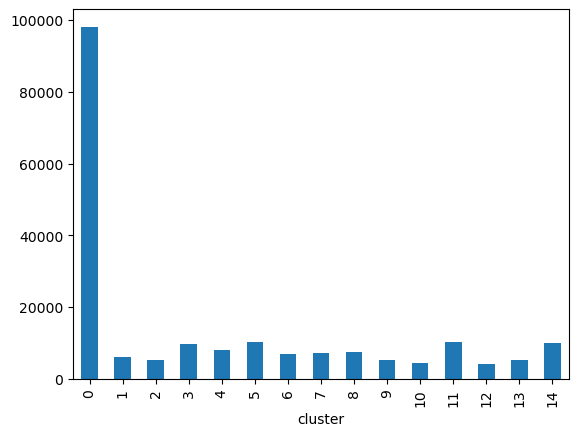

In [41]:
cluster_counts.plot(kind="bar")


In [42]:
def plot_wordclouds_per_cluster(df, lang):
    clusters = sorted(df["cluster"].unique())

    for cluster in clusters:
        df_cluster = df[df["cluster"] == cluster]

        all_tokens = [token for row in df_cluster["tokens"] for token in row]

        if not all_tokens:
            continue

        all_words = " ".join(all_tokens)

        wc = WordCloud(width=800,height=400,background_color="white").generate(all_words)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Cluster {cluster} — {lang}")
        plt.show()



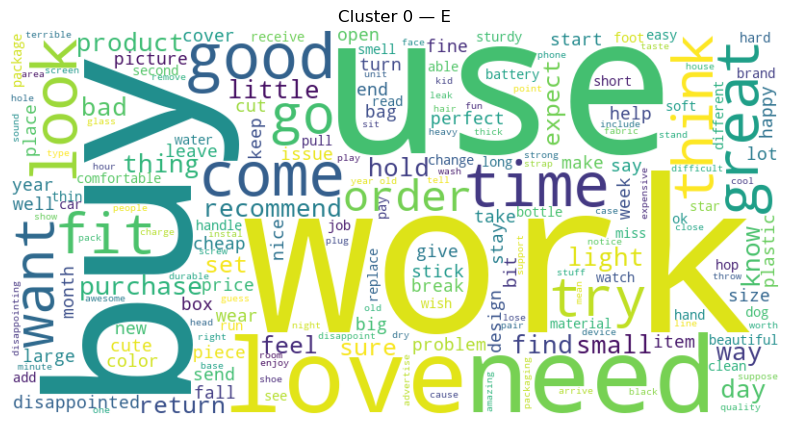

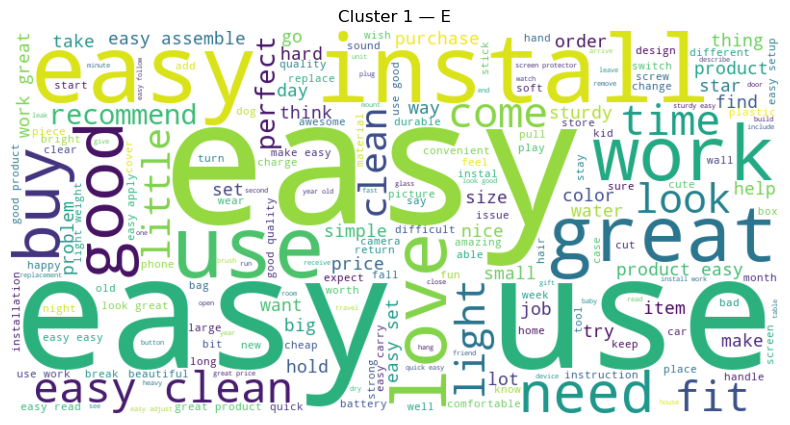

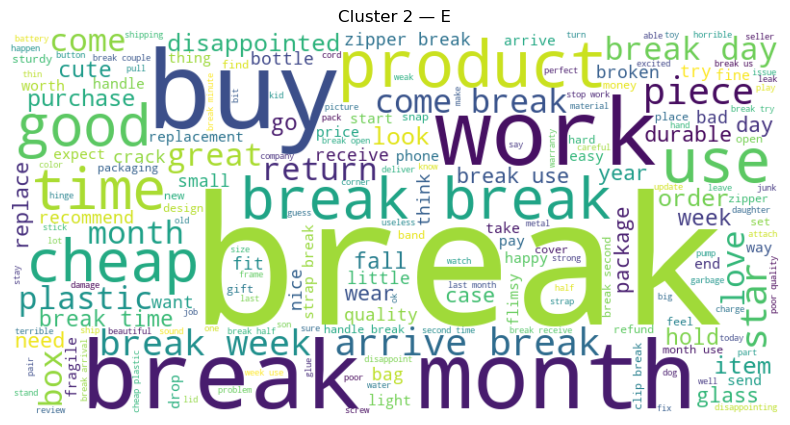

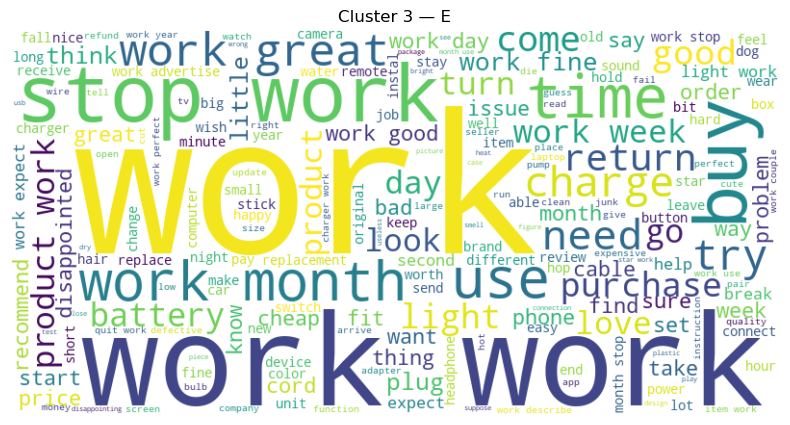

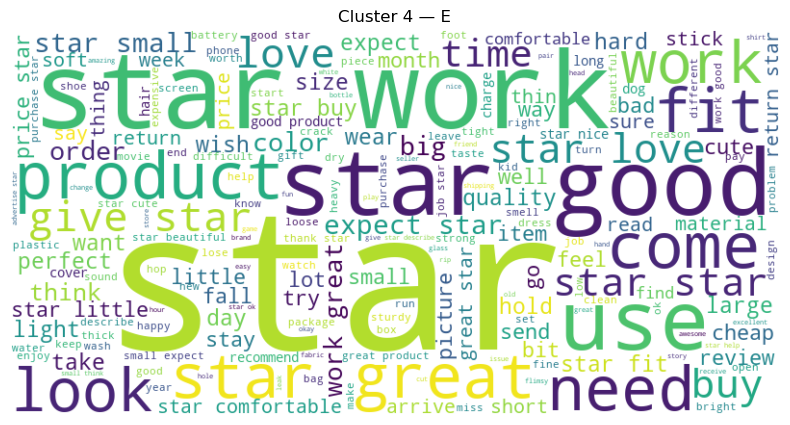

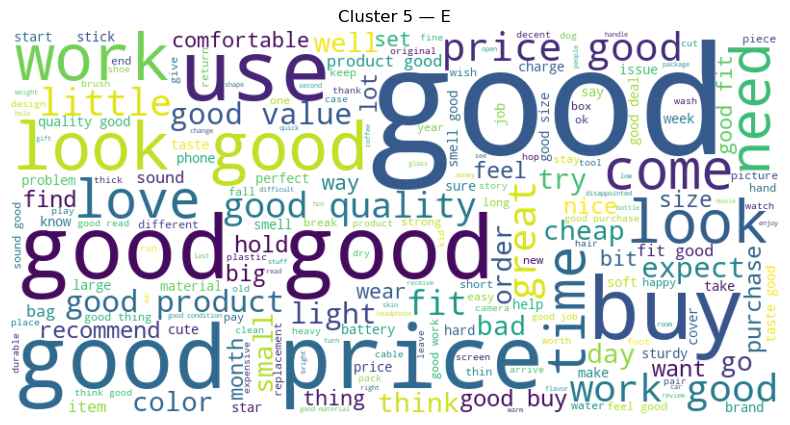

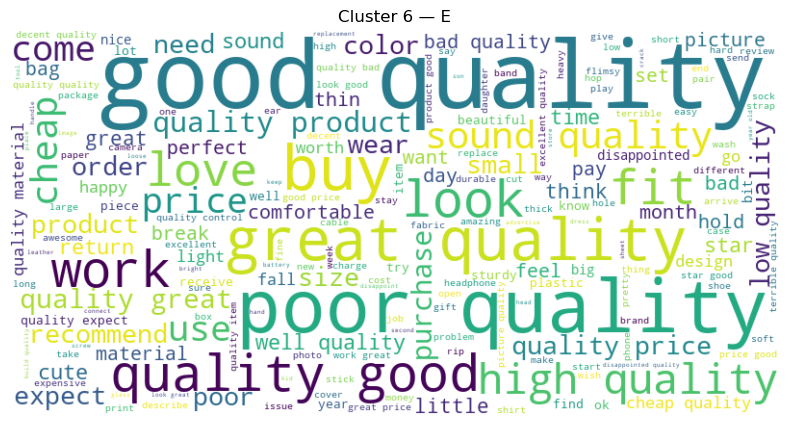

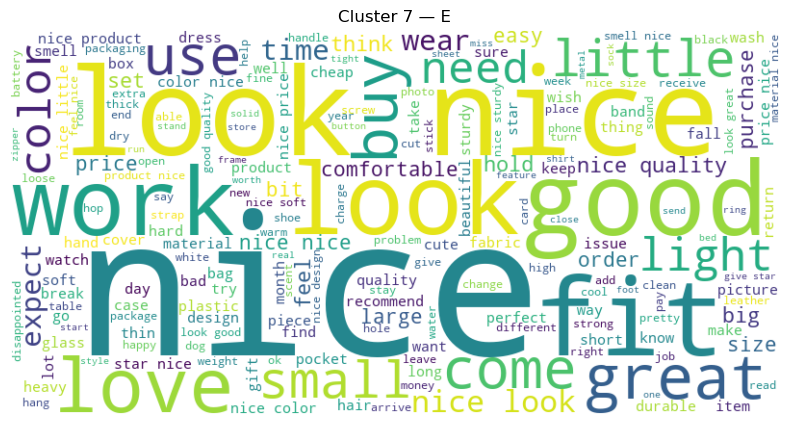

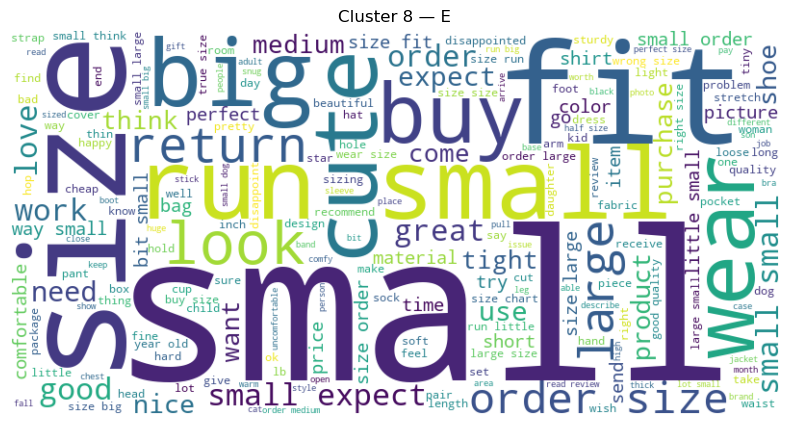

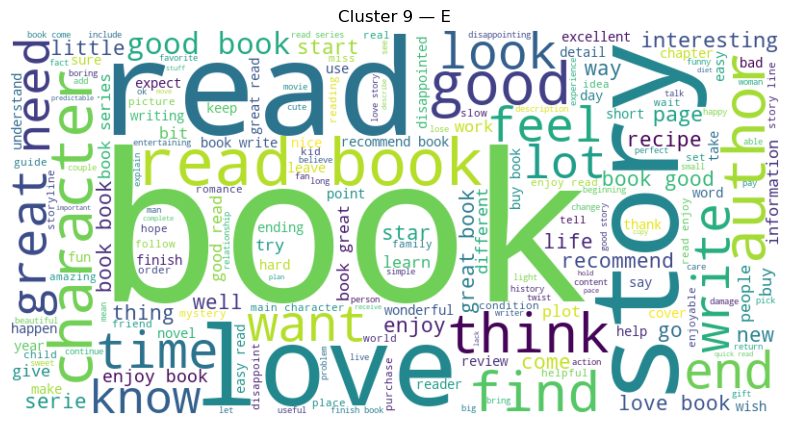

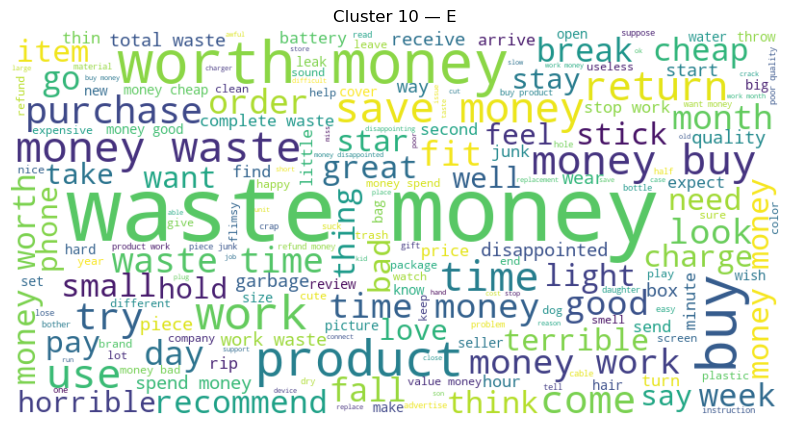

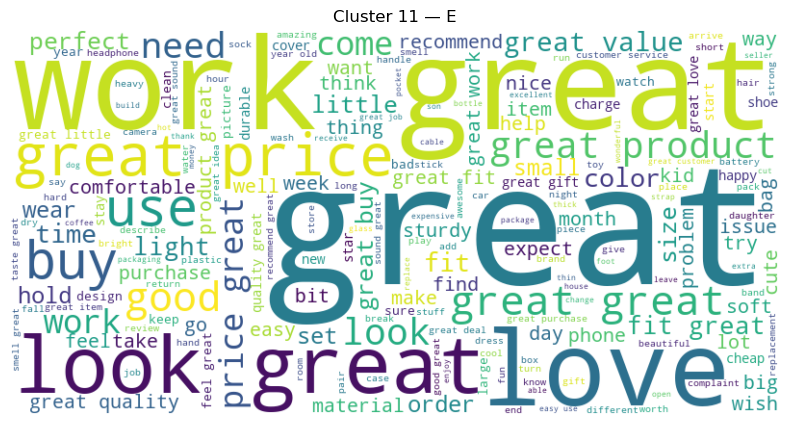

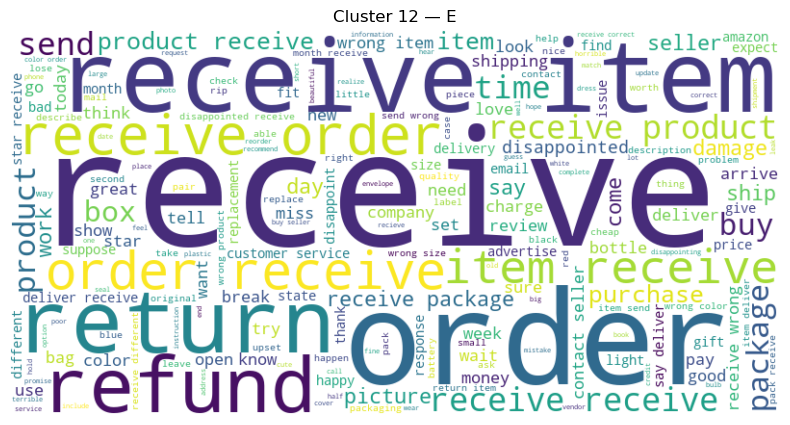

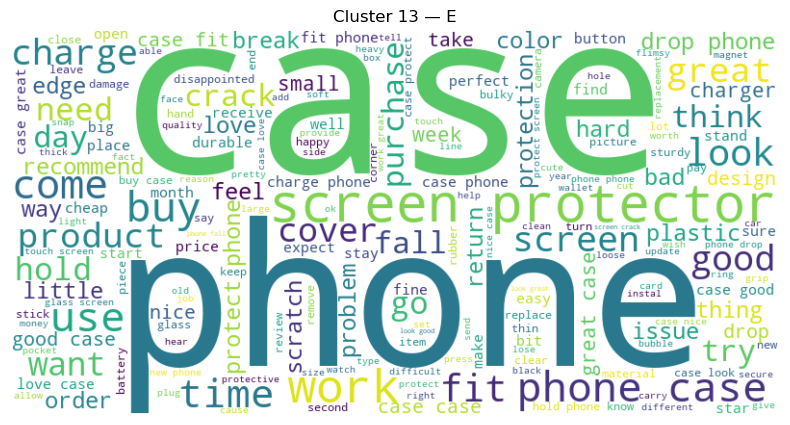

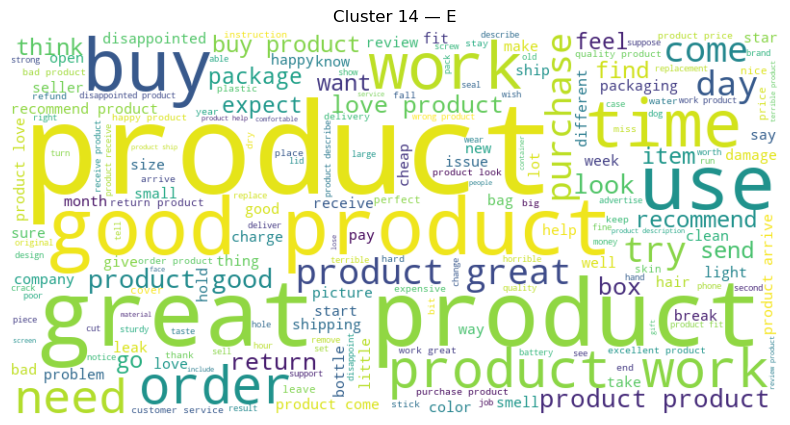

In [43]:
plot_wordclouds_per_cluster(df_en, 'E')

top words per cluster

In [44]:
def top_words_per_cluster(df, top_n=15):
    results = {}

    for cluster in sorted(df["cluster"].unique()):
        df_cluster = df[df["cluster"] == cluster]

        # flatten token lists
        all_tokens = [token for row in df_cluster["tokens"] for token in row]

        if not all_tokens:
            results[cluster] = []
            continue

        token_counts = Counter(all_tokens)
        results[cluster] = token_counts.most_common(top_n)

    return results


In [ ]:
results = top_words_per_cluster(df_en, top_n=15)

for cluster, words in results.items():
    print("\nCluster", cluster)
    print(words)


Cluster 0
[('book', 9690), ('read', 3521), ('good', 1755), ('story', 1606), ('great', 1347), ('love', 1170), ('character', 1072), ('enjoy', 853), ('author', 803), ('series', 775), ('like', 760), ('write', 693), ('time', 655), ('want', 572), ('recommend', 562)]

Cluster 1
[('work', 19897), ('great', 3143), ('buy', 1664), ('stop', 1528), ('time', 1307), ('use', 1285), ('good', 968), ('product', 930), ('week', 868), ('try', 861), ('light', 861), ('charge', 843), ('get', 834), ('day', 810), ('money', 799)]

Cluster 2
[('love', 14071), ('great', 2741), ('buy', 1604), ('look', 1258), ('good', 1068), ('color', 1013), ('work', 982), ('use', 959), ('product', 935), ('easy', 887), ('perfect', 884), ('daughter', 854), ('get', 844), ('cute', 808), ('time', 790)]

Cluster 3
[('great', 19452), ('buy', 16211), ('work', 15926), ('use', 15568), ('look', 14517), ('time', 13072), ('good', 12096), ('come', 11328), ('get', 11024), ('like', 10724), ('nice', 9422), ('need', 9395), ('easy', 8625), ('product'

- probaj "all-MiniLM-L6-v2" posto radis samo engleski

In [45]:
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2") # "all-MiniLM-L6-v2"

# embeddings_en = model.encode(df_en["text_joined"].tolist(), show_progress_bar=True)

path = r"E:\aleksa_praksa\nlp_internship\data-internship\src\saved_models\models\clustering\embeddings_en.npy"
# np.save(path, embeddings_en)

embeddings_en = np.load(path)


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, metric='euclidean')
# labels = clusterer.fit_predict(embeddings_en) # dugo traje bez smanjenja dimenzionalnosti

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [46]:
def plot_hdbscan_clusters(emb_2d, labels):
    unique_labels = np.unique(labels)

    plt.figure(figsize=(10, 8))
    plt.title("HDBSCAN Clusters")

    for lab in unique_labels:
        mask = labels == lab
        plt.scatter(
            emb_2d[mask, 0],
            emb_2d[mask, 1],
            s=10,
            label=f"Cluster {lab}" if lab != -1 else "Noise"
        )
    plt.tight_layout()
    plt.show()

In [ ]:
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
emb_2d = umap_model.fit_transform(embeddings_en)

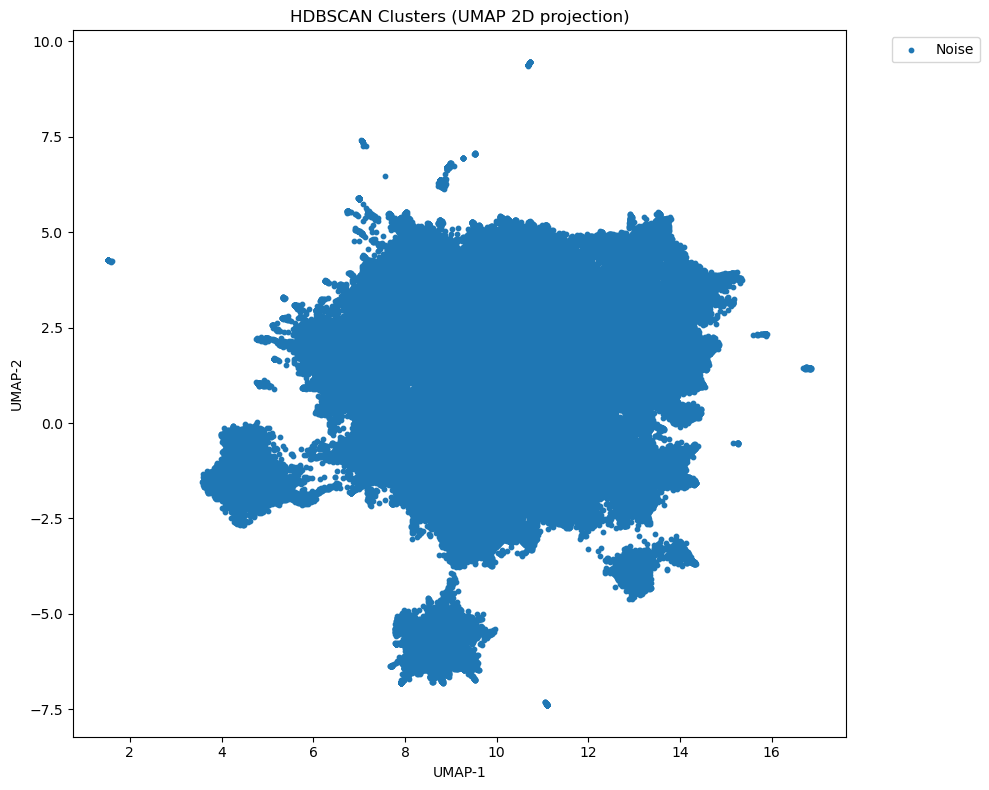

In [ ]:
# plot_hdbscan_clusters(emb_2d, labels)

In [ ]:
pca = PCA(n_components=70)
emb_low_pca = pca.fit_transform(embeddings_en)

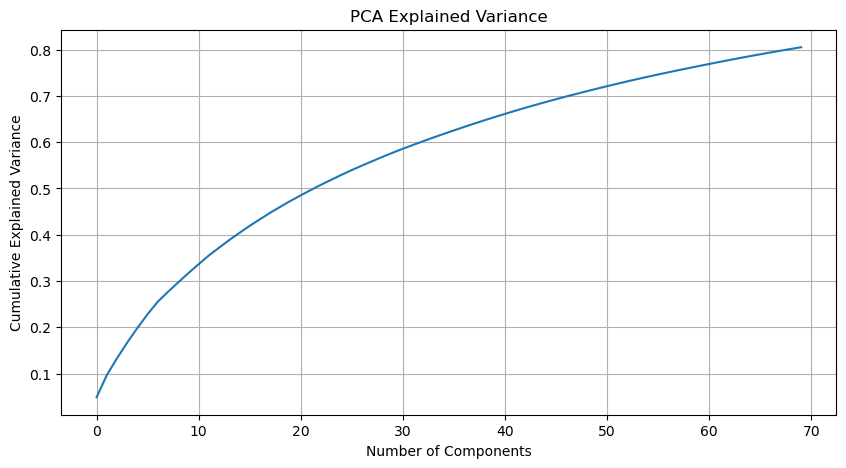

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Components")
plt.ylabel("Variance")

plt.show()


In [ ]:
# clusterer_pca = hdbscan.HDBSCAN(min_cluster_size=200,min_samples=50,metric="euclidean")
# labels_pca = clusterer_pca.fit_predict(emb_low_pca)

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 

: 

In [ ]:
# plot_hdbscan_clusters(emb_2d, labels_pca)

## reducers

In [ ]:
reducer1 = umap.UMAP(n_components=30, n_neighbors=50, metric="euclidean",  verbose=True)
emb_low1 = reducer1.fit_transform(embeddings_en)

UMAP(n_components=30, n_neighbors=50, verbose=True)
Thu Nov 27 10:13:49 2025 Construct fuzzy simplicial set
Thu Nov 27 10:13:50 2025 Finding Nearest Neighbors
Thu Nov 27 10:13:50 2025 Building RP forest with 27 trees
Thu Nov 27 10:14:02 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Thu Nov 27 10:14:50 2025 Finished Nearest Neighbor Search
Thu Nov 27 10:14:55 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Nov 27 10:18:17 2025 Finished embedding


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100,metric='euclidean')
labels = clusterer.fit_predict(emb_low1)

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


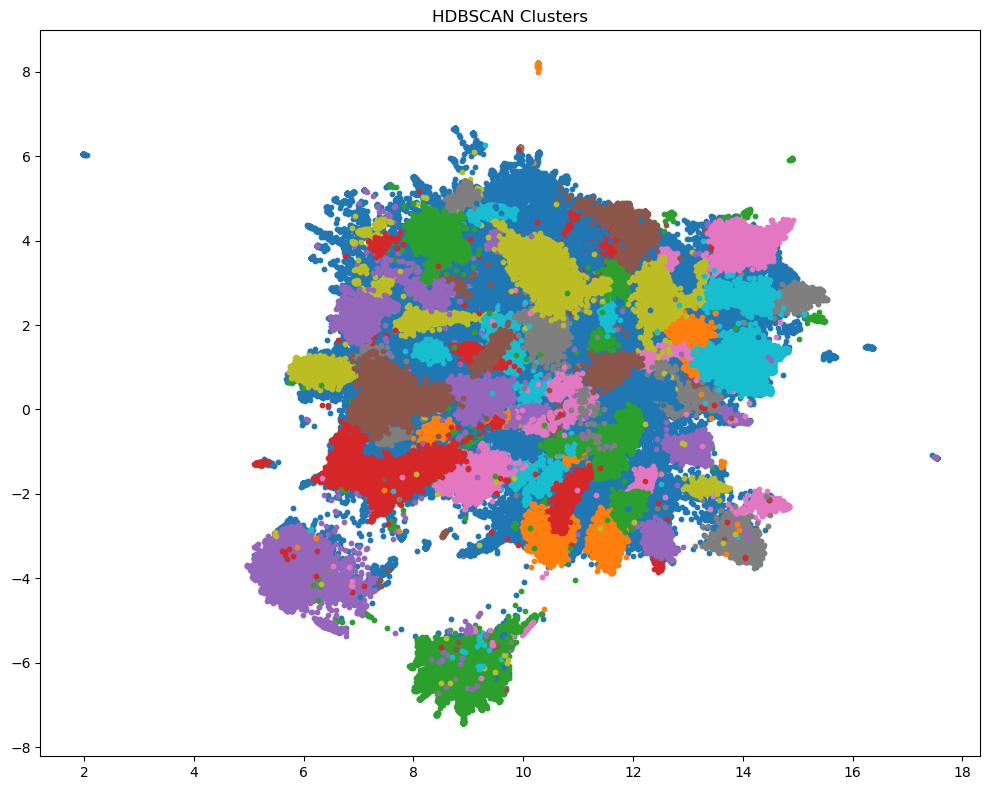

In [ ]:
plot_hdbscan_clusters(emb_2d, labels)

In [ ]:
df_en["cluster"] = labels
df_en["cluster"].unique()

array([-1, 56, 12, 57, 74,  7, 48, 73,  3, 54, 61, 42, 51, 18, 33, 76, 25,
       47,  6, 40,  2, 41, 77, 75, 15, 70, 60, 19, 23,  1, 37, 62, 78, 43,
       59, 30, 24, 13,  5, 31,  8, 32, 22, 49, 58, 45, 20, 16, 65, 46, 38,
       34, 69, 55, 71, 17, 63,  9, 28, 64, 66, 21, 10, 53,  0,  4, 27, 50,
       36, 26, 29, 11, 35, 44, 52, 72, 39, 68, 14, 67])

In [ ]:
results = top_words_per_cluster(df_en)
for cluster, words in results.items():
    print("\nCluster", cluster)
    print(words)


Cluster -1
[('work', 29627), ('good', 23298), ('great', 21654), ('product', 20649), ('buy', 17776), ('use', 16366), ('look', 15896), ('time', 13031), ('fit', 11732), ('love', 11572), ('quality', 11392), ('come', 11059), ('small', 10860), ('get', 10623), ('nice', 9136)]

Cluster 0
[('work', 108), ('know', 2), ('ask', 2), ('fuck', 1), ('us', 1), ('rip', 1), ('piece', 1), ('play', 1), ('throw', 1), ('mad', 1), ('intend', 1), ('song', 1)]

Cluster 1
[('star', 7547), ('work', 1000), ('good', 876), ('great', 774), ('small', 511), ('quality', 466), ('product', 440), ('fit', 406), ('expect', 401), ('like', 397), ('look', 376), ('love', 366), ('price', 349), ('nice', 315), ('use', 303)]

Cluster 2
[('balloon', 330), ('buy', 50), ('helium', 47), ('hole', 43), ('inflate', 43), ('party', 40), ('great', 40), ('blow', 39), ('come', 30), ('pop', 28), ('use', 27), ('fill', 27), ('birthday', 26), ('cute', 25), ('good', 25)]

Cluster 3
[('book', 9597), ('read', 4958), ('story', 3699), ('good', 3426), (

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=80,min_samples=20,metric="euclidean")
labels = clusterer.fit_predict(emb_low1)

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


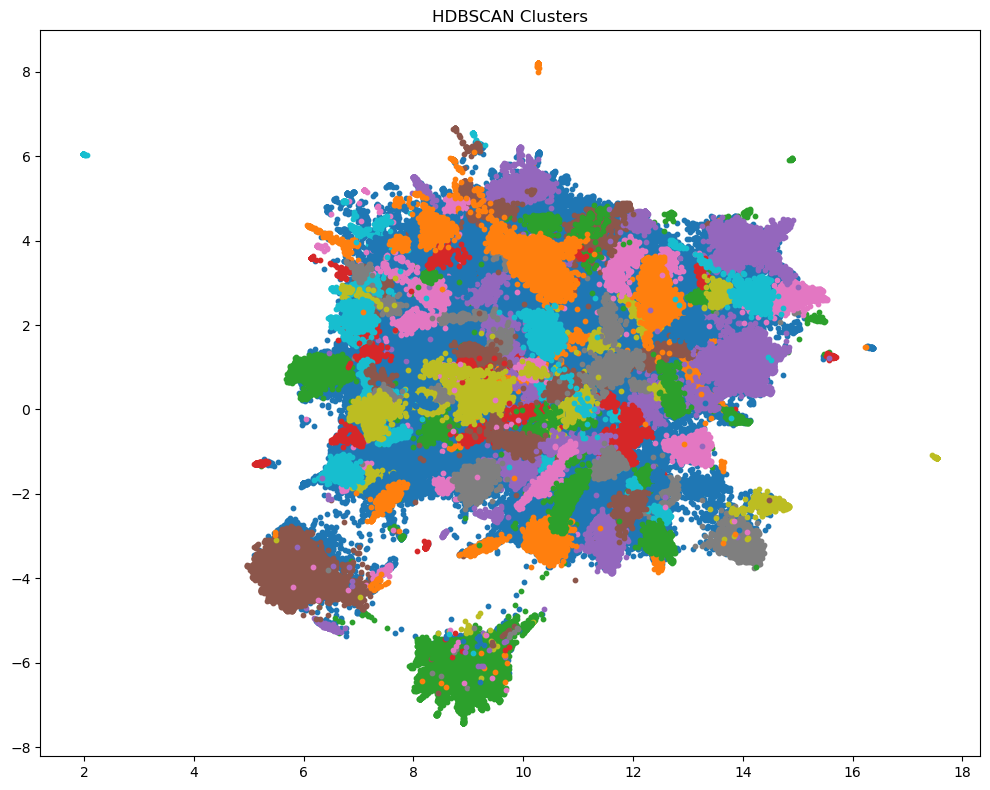

In [ ]:
plot_hdbscan_clusters(emb_2d, labels) # over-clustered

In [ ]:
df_en["cluster"] = labels
df_en["cluster"].unique()

array([ -1, 128,  24, 120,  49,  73, 108,   4,  77, 134, 136, 111,  51,
        23,  27, 115,  56,  70,   6,  83,   2,  44,  84, 132,  61, 133,
       123,  21, 109, 140, 131,   1, 141,  33, 138,  81,  66,  50,  47,
        41,   7,  45,   9,  34,   8,  85,  13,  12,  62,  32, 139, 126,
        94, 102, 117,  64,  68,  76,  54, 118,  14,  43,  16,  74,  71,
        69, 135,  22,  26,  31,  57,  35,  29, 103,  63,  52,  95,  10,
        60,  88,  46,  75, 113, 105,  17, 129,  86,  67,  80,  11, 137,
        37,  91, 100,   0,   5, 130,  65, 121, 114,  53,  93, 107, 122,
        15, 112, 106,  48,  36,  78, 104,  25, 127,  59,  97,  72,  28,
        98, 124,  20,  18,  96,  99,  40,  39,  87,  90, 110,  79,  19,
        38,  58, 101,  82,  30, 119, 116,  92,  89,  55, 125,  42,   3])

In [ ]:
results = top_words_per_cluster(df_en)
for cluster, words in results.items():
    print("\nCluster", cluster)
    print(words)


Cluster -1
[('work', 30754), ('good', 24476), ('great', 23079), ('product', 22408), ('buy', 19391), ('look', 16869), ('use', 16744), ('love', 14037), ('time', 13803), ('fit', 12368), ('quality', 12093), ('come', 11769), ('get', 11464), ('small', 11421), ('order', 10039)]

Cluster 0
[('work', 107), ('ask', 2), ('fuck', 1), ('us', 1), ('rip', 1), ('piece', 1), ('play', 1), ('throw', 1), ('mad', 1), ('know', 1), ('intend', 1), ('song', 1)]

Cluster 1
[('star', 7546), ('work', 1000), ('good', 876), ('great', 774), ('small', 511), ('quality', 466), ('product', 440), ('fit', 406), ('expect', 401), ('like', 397), ('look', 376), ('love', 365), ('price', 349), ('nice', 315), ('use', 303)]

Cluster 2
[('balloon', 336), ('buy', 53), ('helium', 47), ('inflate', 45), ('hole', 43), ('blow', 40), ('party', 40), ('great', 40), ('come', 30), ('pop', 29), ('use', 27), ('fill', 27), ('birthday', 26), ('work', 25), ('cute', 25)]

Cluster 3
[('star', 99), ('book', 75), ('read', 26), ('good', 21), ('enjoy'

In [47]:
reducer2 = umap.UMAP(n_components=60, n_neighbors=50, metric="euclidean",  verbose=False)
emb_low2 = reducer2.fit_transform(embeddings_en)

In [48]:
emb_low2.shape 

(198975, 60)

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200,min_samples=100,metric="euclidean")
labels = clusterer.fit_predict(emb_low2)

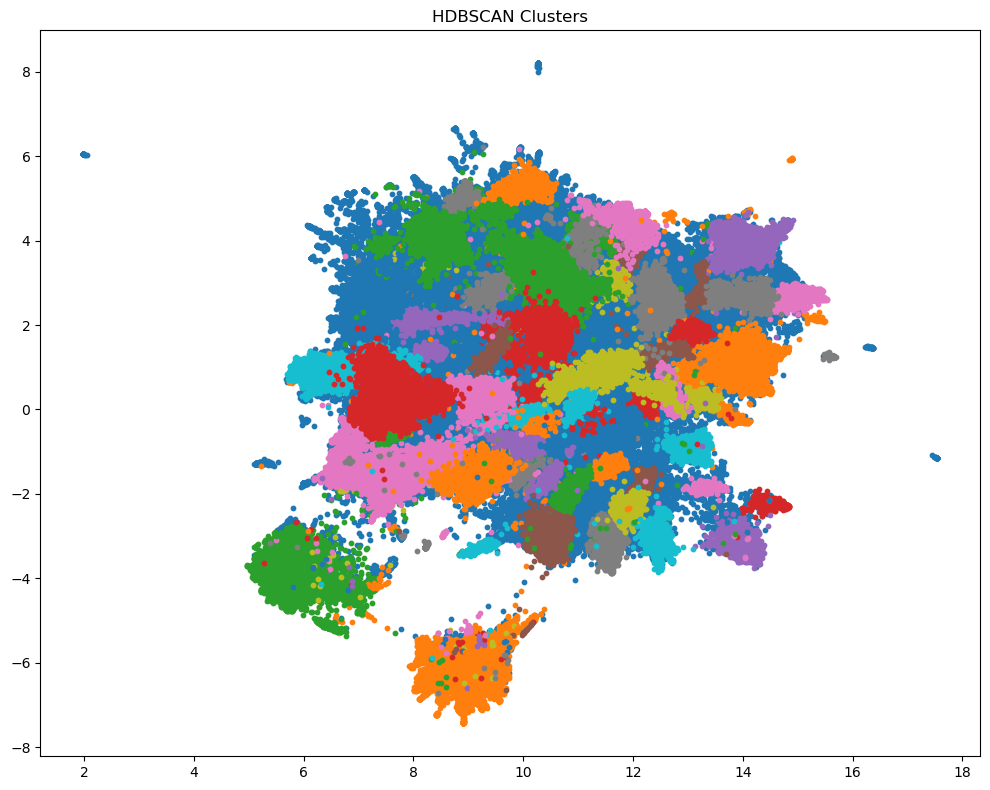

In [ ]:
plot_hdbscan_clusters(emb_2d, labels)

In [ ]:
df_en["cluster"] = labels
df_en["cluster"].unique()

In [ ]:
plot_wordclouds_per_cluster(df_en, 'English')

In [49]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=600,min_samples=200,metric="euclidean", prediction_data=True)
labels = clusterer.fit_predict(emb_low2)

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [51]:
plot_hdbscan_clusters(emb_2d, labels)

NameError: name 'emb_2d' is not defined

In [52]:
df_en["cluster"] = labels
df_en["cluster"].unique()

array([-1, 33, 11, 25, 16,  5, 18, 24, 34, 35, 26,  1, 20, 36, 23, 37,  4,
       17, 31, 14, 19,  2, 28, 30,  9, 13, 10,  0, 32, 29, 21,  7,  3,  8,
        6, 15, 12, 27, 22])

In [53]:
results = top_words_per_cluster(df_en)
for cluster, words in results.items():
    print("\nCluster", cluster)
    print(words)


Cluster -1
[('work', 30564), ('good', 24114), ('great', 22647), ('product', 21682), ('buy', 17644), ('use', 16494), ('look', 16243), ('time', 13537), ('quality', 11650), ('love', 11302), ('come', 11247), ('fit', 10935), ('get', 10649), ('small', 10351), ('easy', 9267)]

Cluster 0
[('star', 7506), ('work', 989), ('good', 860), ('great', 766), ('small', 515), ('quality', 459), ('product', 437), ('fit', 406), ('expect', 399), ('like', 394), ('look', 374), ('love', 368), ('price', 349), ('nice', 308), ('use', 303)]

Cluster 1
[('book', 9587), ('read', 4957), ('story', 3701), ('good', 3435), ('love', 2462), ('great', 2209), ('character', 2043), ('movie', 1448), ('like', 1359), ('time', 1312), ('enjoy', 1283), ('series', 1259), ('author', 1147), ('write', 1091), ('think', 978)]

Cluster 2
[('dog', 3523), ('work', 751), ('love', 642), ('good', 620), ('great', 602), ('product', 578), ('small', 568), ('buy', 446), ('like', 399), ('puppy', 395), ('get', 381), ('use', 380), ('time', 338), ('coll

In [58]:
cluster_counts = df_en["cluster"].value_counts().sort_index()
cluster_counts

cluster
-1     106501
 0       7388
 1      10071
 2       2900
 3       1031
 4       1347
 5        928
 6        720
 7        859
 8        629
 9       5050
 10      1920
 11      1167
 12       754
 13       913
 14      2741
 15       619
 16      4462
 17      2491
 18      4808
 19      3081
 20      1021
 21      2445
 22      1365
 23      3894
 24      1524
 25      5407
 26      4582
 27       609
 28      2204
 29      1376
 30      1030
 31      2022
 32      1534
 33      1032
 34      3073
 35      2647
 36      1813
 37      1017
Name: count, dtype: int64

<Axes: xlabel='cluster'>

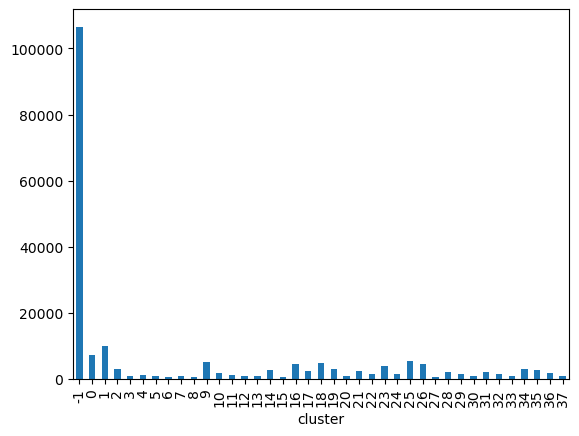

In [59]:
cluster_counts.plot(kind="bar")

In [60]:
SAVE_PATH = r"E:\aleksa_praksa\nlp_internship\data-internship\src\saved_models\models\clustering"

joblib.dump(reducer2, SAVE_PATH + r"\reducer.pkl")

['E:\\aleksa_praksa\\nlp_internship\\data-internship\\src\\saved_models\\models\\clustering\\reducer.pkl']

In [61]:
joblib.dump(clusterer, SAVE_PATH + r"\clusterer.pkl")

['E:\\aleksa_praksa\\nlp_internship\\data-internship\\src\\saved_models\\models\\clustering\\clusterer.pkl']

In [ ]:
plot_wordclouds_per_cluster(df_en, 'English')

In [ ]:
cluster_names = {
    -1: "General / Mixed Product Feedback",

     0: "Star Rating & Expectations",
     1: "Books & Literature",
     2: "Cat Supplies",
     3: "Dog Supplies",

     4: "Watch Bands & Accessories",
     5: "Gardening & Seeds",
     6: "Jewelry & Accessories",

     7: "Bedding & Sleep Products",
     8: "Terrible / Waste of Money",
     9: "Printer Ink & Office Supplies",

    10: "Chairs & Seating",
    11: "Colors, Looks & Appearance",
    12: "Breakage & Short Lifespan",

    13: "Games & Entertainment",
    14: "Good Quality & Value",
    15: "Kids’ Toys & Gifts",

    16: "Lights & Bulbs",
    17: "Phone Cases & Screen Protectors",
    18: "Bags, Backpacks & Wallets",

    19: "Stops Working / Lifetime Issues",
    20: "Tools, Hardware & DIY",
    21: "Battery, Charging & Cables",

    22: "Audio: Headphones & Speakers",
    23: "Size Issues (Runs Small / Wrong Fit)",
    24: "Clothing (Dresses, Shirts)",

    25: "Shoes, Socks & Footwear",
    26: "Smell, Fragrance & Odor Complaints",
    27: "Skincare Products",

    28: "Haircare & Brushes",
    29: "Order, Shipping & Refund Problems",
    30: "Package Damage",

    31: "Water Equipment (Hose, Pump, Filter)",
    32: "Coffee, Tea & Drinkware",
    33: "Taste & Flavor of Food Products"
}


In [ ]:
df_en["cluster_name"] = df_en["cluster"].map(cluster_names)

In [ ]:
df_en

review_body  \
172073  Arrived broken. Manufacturer defect. Two of th...   
172074  the cabinet dot were all detached from backing...   
172075  I received my first order of this product and ...   
172076  This product is a piece of shit. Do not buy. D...   
172077  went through 3 in one day doesn't fit correct ...   
...                                                   ...   
622385  This ribbon is so adorable! Goes perfect with ...   
622386                     I am in love with this kettle.   
622387  My Doberman Loves Having His Nails Trimmed and...   
622388  I love my Fire.. I do everything on it, read, ...   
622389  A wish I would've ordered one size smaller (I ...   

                                             review_title language  \
172073  I'll spend twice the amount of time boxing up ...       en   
172074                                       Not use able       en   
172075                               The product is junk.       en   
172076                             Fucking waste of money       en   
172077                                             bubble       en   
...                                                   ...      ...   
622385                                           So Cute!       en   
622386                                            Perfect       en   
622387                             My Doberman Loves Them       en   
622388                                         Five Stars       en   
622389                                        SUPER CUTE!       en   

        product_category                                      combined_text  \
172073         furniture  I'll spend twice the amount of time boxing up ...   
172074  home_improvement  Not use able the cabinet dot were all detached...   
172075              home  The product is junk. I received my first order...   
172076          wireless  Fucking waste of money This product is a piece...   
172077                pc  bubble went through 3 in one day doesn't fit c...   
...                  ...                                                ...   
622385              home  So Cute! This ribbon is so adorable! Goes perf...   
622386           kitchen             Perfect I am in love with this kettle.   
622387      pet_products  My Doberman Loves Them My Doberman Loves Havin...   
622388             other  Five Stars I love my Fire.. I do everything on...   
622389           apparel  SUPER CUTE! A wish I would've ordered one size...   

        word_count                                             tokens  \
172073         134  [spend, time, box, useless, thing, send, star,...   
172074          13       [use, able, cabinet, dot, detach, back, get]   
172075          44  [product, junk, receive, order, product, break...   
172076          33  [waste, money, product, piece, shit, buy, work...   
172077          17            [bubble, go, day, fit, correct, bubble]   
...            ...                                                ...   
622385          17  [cute, ribbon, adorable, go, perfect, elf, the...   
622386           8                            [perfect, love, kettle]   
622387          38  [love, love, have, trim, ear, clean, present, ...   
622388          15         [star, love, fire, read, play, game, bank]   
622389          50  [wish, order, size, small, little, long, great...   

                                              text_joined  cluster  \
172073  spend time box useless thing send star review ...       -1   
172074               use able cabinet dot detach back get       -1   
172075  product junk receive order product break order...       30   
172076  waste money product piece shit buy work try cu...        8   
172077                   bubble go day fit correct bubble       -1   
...                                                   ...      ...   
622385  cute ribbon adorable go perfect elf theme tree...       -1   
622386                                perfect love kettle       15   
622387  love lov

In [ ]:
def top_words_per_cluster(df, top_n=15):
    results = {}

    for cluster in sorted(df["cluster"].unique()):
        df_cluster = df[df["cluster"] == cluster]

        # flatten token lists
        all_tokens = [token for row in df_cluster["tokens"] for token in row]

        if not all_tokens:
            results[cluster] = []
            continue

        token_counts = Counter(all_tokens)
        results[cluster] = token_counts.most_common(top_n)

    return results

In [ ]:
results = top_words_per_cluster(df_en)
for cluster, words in results.items():
    cluster_name = cluster_names.get(cluster, "Unknown Cluster")

    print(f"\nCluster {cluster} — {cluster_name}")
    print(words)


Cluster -1 — General / Mixed Product Feedback
[('work', 27924), ('good', 23310), ('great', 21876), ('product', 20618), ('buy', 17544), ('look', 16681), ('use', 16027), ('time', 13260), ('fit', 12411), ('love', 11985), ('small', 11725), ('come', 11281), ('quality', 11224), ('get', 10656), ('order', 9690)]

Cluster 0 — Star Rating & Expectations
[('star', 7521), ('work', 992), ('good', 868), ('great', 763), ('small', 514), ('quality', 461), ('product', 438), ('fit', 402), ('expect', 398), ('like', 397), ('look', 374), ('love', 368), ('price', 348), ('nice', 311), ('use', 303)]

Cluster 1 — Books & Literature
[('book', 9566), ('read', 4955), ('story', 3700), ('good', 3423), ('love', 2466), ('great', 2209), ('character', 2043), ('movie', 1444), ('like', 1359), ('time', 1313), ('enjoy', 1280), ('series', 1259), ('author', 1146), ('write', 1093), ('think', 976)]

Cluster 2 — Cat Supplies
[('cat', 1580), ('love', 296), ('work', 214), ('food', 198), ('good', 196), ('buy', 176), ('great', 173)

In [ ]:
path = r"E:\aleksa_praksa\nlp_internship\data-internship\src\saved_models\models\clustering\clusterer.pkl"

with open(path, "rb") as f:
    clusterer = pickle.load(f)

# English-only model (all-MiniLM-L12-v2)

In [ ]:
df["text_joined"] = df["tokens"].apply(lambda x: " ".join(x))
df_en = df[df["language"] == "en"].copy()

In [ ]:
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings_en2 = model.encode(df_en["text_joined"].tolist(), show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aleksa.cosovic\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/6218 [00:00<?, ?it/s]

In [ ]:
reducer2 = umap.UMAP(n_components=60, n_neighbors=50, metric="euclidean",  verbose=True)
emb_low2 = reducer2.fit_transform(embeddings_en2)

UMAP(n_components=60, n_neighbors=50, verbose=True)
Thu Nov 27 14:06:28 2025 Construct fuzzy simplicial set
Thu Nov 27 14:06:28 2025 Finding Nearest Neighbors
Thu Nov 27 14:06:28 2025 Building RP forest with 27 trees
Thu Nov 27 14:06:40 2025 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	 3  /  18
	 4  /  18
	 5  /  18
	Stopping threshold met -- exiting after 5 iterations
Thu Nov 27 14:07:26 2025 Finished Nearest Neighbor Search
Thu Nov 27 14:07:32 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Nov 27 14:11:32 2025 Finished embedding


In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=600,min_samples=200,metric="euclidean")
labels = clusterer.fit_predict(emb_low2)

c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\aleksa.cosovic\AppData\Local\anaconda3\envs\myenv\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
df_en["cluster"] = labels
df_en["cluster"].unique()

array([-1, 32, 33, 30,  2, 11, 24,  1,  3,  5, 34,  9, 21, 28, 25, 13, 37,
       14, 15,  0, 16, 17,  8, 10, 20, 22, 38, 36, 26, 31, 35,  6, 18, 29,
       27,  7,  4, 23, 19, 12])

In [ ]:
results = top_words_per_cluster(df_en)
for cluster, words in results.items():
    print("\nCluster", cluster)
    print(words)


Cluster -1
[('work', 23064), ('good', 17541), ('great', 17003), ('product', 15596), ('buy', 12689), ('use', 12451), ('look', 11606), ('time', 9334), ('love', 9007), ('quality', 8391), ('come', 8062), ('small', 7912), ('get', 7482), ('fit', 7245), ('easy', 6880)]

Cluster 0
[('star', 7763), ('work', 1097), ('good', 922), ('great', 814), ('product', 534), ('small', 523), ('quality', 488), ('look', 437), ('fit', 420), ('expect', 418), ('like', 403), ('love', 396), ('price', 362), ('use', 353), ('nice', 340)]

Cluster 1
[('book', 9557), ('read', 5076), ('story', 3732), ('good', 3481), ('love', 2345), ('great', 2188), ('character', 2065), ('movie', 1449), ('like', 1352), ('time', 1337), ('enjoy', 1279), ('series', 1270), ('author', 1141), ('write', 1088), ('think', 964)]

Cluster 2
[('dog', 2989), ('cat', 1394), ('work', 1276), ('love', 1005), ('good', 885), ('great', 851), ('product', 788), ('small', 777), ('buy', 688), ('get', 615), ('like', 596), ('use', 585), ('time', 549), ('collar', 

## Evaluation

- Silhouette score is used to assess clustering quality.

For each point i:

a(i) = average distance to all other points in its cluster  
b(i) = distance to the nearest other cluster

Silhouette for that point:

s(i) = (b(i) - a(i)) / max(a(i), b(i))

K-Means → silhouette computed for all points  
HDBSCAN → silhouette computed only for non-noise points  
(noise points have label -1, so silhouette is not defined for them)

Silhouette Score requires:

1. Distances between points → you need embeddings  
2. Cluster labels → you need labels

Silhouette =
(distance to own cluster − distance to nearest other cluster) / max(...)


In [ ]:
from sklearn.metrics import silhouette_score

In [ ]:
mask = labels != -1

In [ ]:
filtered_embeddings = emb_low2[mask]
filtered_labels = labels[mask]

score = silhouette_score(filtered_embeddings, filtered_labels)


In [ ]:
print(
    "Silhouette Score using:\n"
    "• SentenceTransformer embeddings (paraphrase-multilingual-MiniLM-L12-v2)\n"
    "• UMAP (n_components=60, n_neighbors=50, metric='euclidean')\n"
    "• HDBSCAN (min_cluster_size=600, min_samples=200, metric='euclidean')"
)

print(f"Score: {score:.4f}")


Silhouette Score using:
• SentenceTransformer embeddings (MiniLM-L12-v2)
• UMAP (n_components=60, n_neighbors=50, metric='euclidean')
• HDBSCAN (min_cluster_size=600, min_samples=200, metric='euclidean')
Score: 0.6255


In [ ]:
score_k = silhouette_score(X_en_tfidf, k_mean_labels, metric="euclidean")
print("KMeans Silhouette Score:", score)

KMeans Silhouette Score: 0.6254618763923645
